In [1]:
%matplotlib inline
import sympy
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from sympy import Matrix, MatrixSymbol, Symbol, symbols, cos, sin, BlockMatrix
from scipy.linalg import solve_continuous_are
from scipy.signal import place_poles, step, lti
from scipy import signal
from tqdm import tqdm
import code.dynamics as dy
from code.utils import plot_respone
from code.controller import Controller 
import code.systems as Z
from scipy.integrate import solve_ivp
from functools import partial

## Declare the symbols

In [3]:
ctrl = Controller()
x, theta1, theta2, u = (dy.x, dy.theta1, dy.theta2, dy.u)
x_dot, theta1_dot, theta2_dot = (dy.x_dot, dy.theta1_dot, dy. theta2_dot)
x_ddot, theta1_ddot, theta2_ddot = (dy.x_ddot, dy.theta1_ddot, dy. theta2_ddot)
state = Matrix([x,x_dot, theta1, theta1_dot, theta2, theta2_dot])

# variables
m1, m2, M = (dy.m1, dy.m2, dy.M)
l1, l2 = (dy.l1, dy.l2)
g = dy.g

variables = dy.variables

In [4]:
state

Matrix([
[             x],
[       \dot{x}],
[      \theta_1],
[\dot{\theta_1}],
[      \theta_2],
[\dot{\theta_2}]])

In [5]:
N = dy.N #number of tate
R = Matrix([.003])
Q = sympy.eye(N,N)*150

A_sub = dy.A.subs(variables)
B_sub = dy.B.subs(variables)
A_arr = np.array(A_sub,dtype=np.float32)
B_arr = np.array(B_sub,dtype=np.float32)
Q_arr = np.array(Q,dtype=np.float32)
R_arr = np.array(R,dtype=np.float32)

## Observability of state space

In [7]:
C1 = (Matrix([[1,0,0,0,0,0]]),x)
C2 = (Matrix([[0,0,1,0,0,0],[0,0,0,0,1,0]]),(theta1,theta2))
C3 = (Matrix([[1,0,0,0,0,0],[0,0,0,0,1,0]]),(x,theta2))
C4 = (Matrix([[1,0,0,0,0,0],[0,0,1,0,0,0],[0,0,0,0,1,0]]),(x,theta1,theta2))
Cs_temp = [C1,C2,C3,C4]
Cs = []
for c,st in Cs_temp:
    
    observer =  Matrix(BlockMatrix([[c*dy.A**i] for i in range(N)]))
    rk = observer.rank()
    if rk==N:
        # sympy.pprint(st)
        print(f"{st} is observable")
        Cs.append((c,st))
    else:
        print(f"{st} is not observable")

x is observable
(\theta_1, \theta_2) is not observable
(x, \theta_2) is observable
(x, \theta_1, \theta_2) is observable


## Luenberger Observer

In [8]:
# Find the L for above given output vector
# Fixing eigen values for the A-L, we can reversely find L
Ls = []
eig = np.array(Matrix([-1,-1.5,-2, -2.5, -3,-3.5]),dtype=np.float32).reshape(-1,)
for c, st in Cs:
    C_arr = np.array(c.T,dtype=np.float32)
    print(C_arr.shape,A_arr.shape)
    out = place_poles(A_arr,C_arr,eig)
    O = np.round_(out.gain_matrix,3)
    L = Matrix(O).T
    Ls.append(L)
    print(L)
    # print(sympy.latex(L))

(6, 1) (6, 6)
Matrix([[2.50000000000000], [-1.99707132797425e+15], [1.95631477026049e+15], [2.26334750503748e+15], [-3.30671538250974e+15], [4.77123435635752e+15]])
(6, 2) (6, 6)


/home/skynet/.local/lib/python3.8/site-packages/scipy/signal/_ltisys.py:3358: UserWarning: Convergence was not reached after maxiter iterations.
You asked for a relative tolerance of 0.001000 we got 1.000000
  warnings.warn(err_msg)


Matrix([[3.03500000000000, 0.0470000000000000], [-5.53898384948067e+15, -248048348358178.], [4010.61700000000, -296.014000000000], [9.23163971407697e+15, 413413912360345.], [-25.9380000000000, 6.87900000000000], [4.61581985703909e+15, 206706956180179.]])
(6, 3) (6, 6)
Matrix([[1.64500000000000, 0.605000000000000, -0.0850000000000000], [-352680596653506., 2.57701537016985e+15, 70493020208623.1], [0.333000000000000, 5.32600000000000, 0.871000000000000], [587800992190371., -4.29502560063966e+15, -117488366568221.], [-0.106000000000000, 2.90600000000000, 5.33700000000000], [293900496095186., -2.14751280031983e+15, -58744183284113.8]])


### Non Linear Repone of Luenber Oberver

(3, 50000)
3


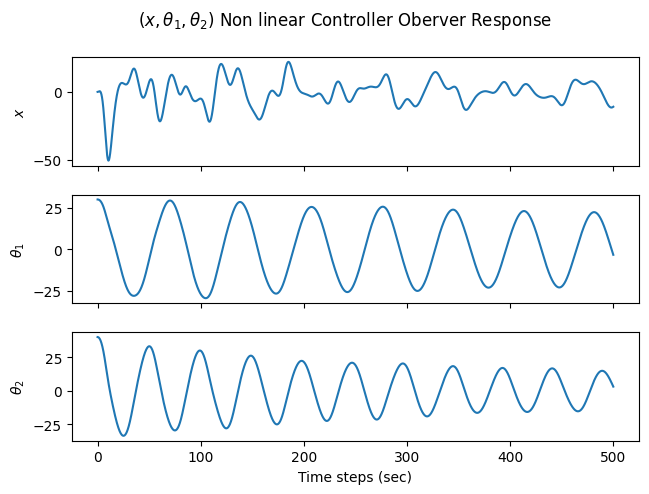

In [ ]:
# Non linear response for Luenberger response
i = 2
L_arr = np.array(Ls[i],dtype=np.float32)
C_arr = np.array(Cs[i][0],dtype=np.float32)
A_l = A_arr - L_arr@C_arr
ode =  ctrl.ode_for_observer(A_l)

Y = np.array([0,0,30,0,40,0,0,0,0,0,0,0]).reshape(-1,)
T = np.linspace(0,500,50000)
# ode(T,Y)
ol = solve_ivp(ode,(0,500),Y,t_eval=T)
time_steps = np.linspace(0,500,ol.y.shape[1])
Y_ARR =  np.vstack([ol.y.T[:,0],ol.y.T[:,2],ol.y.T[:,4]])
print(Y_ARR.shape)
plot_respone(Y_ARR.T,time_steps,N,Cs[i][1],plot_title=f"${Cs[i][1]}$ Non linear Controller Oberver Response",Plot_filename="x_theta1_theta2_Controller+OberverNonLinearResponse", save=False)

In [ ]:
## Running Luenber Observer and Get Response for 3 observable output vectors

## Assuming Estimation Error
Est_error_state = Matrix([100,100,100,100,100,100])

all_step_output = []
all_output_arr_control_observe = []
all_output_arr_control_observe_non_linear = []
all_sys = []
X_states = {x:0,x_dot:0, theta1:30, theta1_dot:0, theta2:40, theta2_dot:0, u:0}
## Auming the initial etimate error to be 100 for all states
states = Matrix(BlockMatrix([[dy.state],[Est_error_state]])) # state with state estimates
for c, l in zip(Cs,Ls):
    output_arr_control_observe, all_states , time_steps, sys = Z.state_space_observer(A_sub,B_sub,c[0],l,K,X_states,states)
    all_output_arr_control_observe.append(output_arr_control_observe)
    t, Y = signal.step2(sys,T=time_steps)
    all_step_output.append(Y)
    all_sys.append(sys)
    break

In [ ]:
plot_respone(all_output_arr_control_observe[0],time_steps,N,Cs[0][1],plot_title=f"${Cs[0][1]}$ Controller Oberver Response",Plot_filename="x_Controller+OberverResponse", save=False)

In [ ]:
# plot_respone(all_output_arr_control_observe[2],time_steps,N,Cs[2][1],plot_title=f"${Cs[2][1]}$ Controller Oberver Response",Plot_filename="x_theta1_theta2_Controller+OberverResponse-non-linear", save=False)

In [ ]:
# plot_respone(all_step_output[2],time_steps,N,Cs[2][1], plot_title=f"${Cs[2][1]}$ Step Response", Plot_filename ="x_theta1_theta2_Controller+OberverStepResponse",save=True)

## LQG Controller

In [ ]:
# zero mean covariance matrix for state and for output x vector
BdCov_ubBd = 0.3*np.identity(N) # Process noise covariance
cov_vd = np.array([1]).reshape(1,1) # measurement noise covariance

X_states = {x:0,x_dot:0, theta1:30, theta1_dot:0, theta2:40, theta2_dot:0, u:0}
states = Matrix(BlockMatrix([[dy.state],[Matrix([100,100,100,100,100,100])]])) # state with state estimates
for c in Cs:
    C_arr = np.array(c[0],dtype=np.float32)
    optimal_L = ctrl.lqg(A_arr.T,C_arr.T,BdCov_ubBd,cov_vd)
    output_arr_control_observe, all_states, time_steps, sys = Z.state_space_observer(A_sub,B_sub,c[0],optimal_L,K,X_states,states)
    break

In [ ]:
## PLotting Linear Response
plot_respone(all_states[:,0],time_steps,N,state,plot_title=f"${Cs[0][1]}$ LQG Controller Oberver Linear Response",Plot_filename="x_LQG_Controller+OberverLinearResponse", save=False)

In [ ]:
c = Cs[0]
C_arr = np.array(c[0],dtype=np.float32)
optimal_L = ctrl.lqg(A_arr.T,C_arr.T,BdCov_ubBd,cov_vd)
# A_block = Matrix(BlockMatrix([[A_sub+B_sub*K,-B_sub*K],[sympy.zeros(*A_sub.shape),A_sub-optimal_L*c[0]]]))
A_lqg = A_arr - optimal_L@C_arr

6


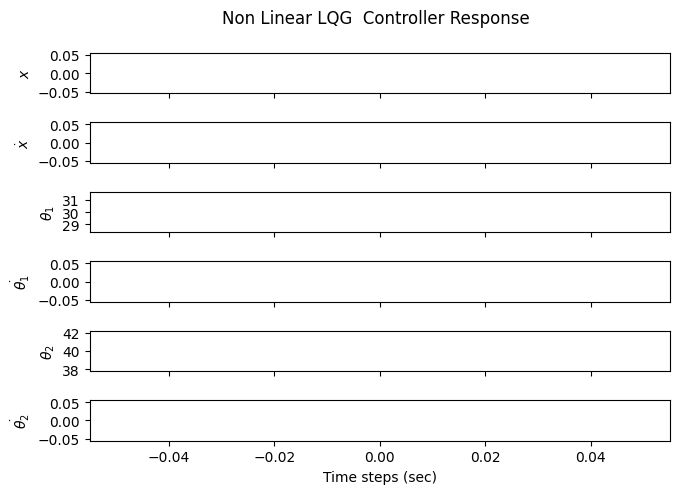

In [ ]:
# Non linear plotting
ode =  ctrl.ode_for_observer(A_l)
Y = np.array([0,0,30,0,40,0,100,0,0,0,0,0]).reshape(-1,)
T = np.linspace(0,500,50000)
# ode(T,Y)
ol = solve_ivp(ode,(0,500),Y,t_eval=T)
time_steps = np.linspace(0,500,ol.y.shape[1])
plot_respone(ol.y.T,time_steps,N,state,plot_title="Non Linear LQG  Controller Response", Plot_filename="Non Linear LQG Controller Response",save=False)

In [ ]:
plot_respone(ol.y.T[:,6:],time_steps,N,state,plot_title="Non Linear LQG  Controller Response", Plot_filename="Non Linear LQG Controller Response",save=False)